<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_detection.ipynb)


#                                   Pneumonia Detection
![Pneumonia](https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg)
## Background of Pneumonia and importance of CXR Review
 Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in lungs, which are called alveoli. In a person with pneumonia the alveoli are filled with pus and fluid, which makes breathing painful and reduces the oxygen intake. 
 It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams.
  Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. 
 Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR.
 
## Problem Interpretation:
 CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
Hence, There is acute need to assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). 
Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

## Objective:
- The goal is to build a pneumonia detection system and to locate the position of inflammation in a chest radiograph (CXR) image. 
- We are challenged to build an algorithm to detect a visual signal for pneumonia in medical images. 
- That is our algorithm needs to automatically locate lung opacities on chest radiographs.

In the process we will be:
 - Learning how to build an Object Detection Model.
 - Use transfer learning to fine-tune a model. 
 - Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.
 - Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

## Data files available for the project
**Training & Test Image files:** 
- stage_2_train_images.zip
- stage_2_test_images.zip
- Medical images are stored in a special format called DICOM files (*.dcm). 
- All provided images are in DICOM format.
- Each patientId corresponds to a unique image.
- They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

**Training data 1:**  
- stage_2_train_labels.csv
- Contains patientIds with bounding box information and binary Target variable 0 or 1(negative or positive evidence of pneumonia).
- Following bounding box information are available:
 - x - the upper-left x coordinate of the bounding box.
 - y - the upper-left y coordinate of the bounding box.
 - width  - the width of the bounding box.
 - height - the height of the bounding box.
 - There can be multiple rows per **patientId** in the training data which refers to more than one bounding box for the patientId.

**Trainging data 2:**
- stage_2_detailed_class_info.csv
- Contains patientIds with class details: No Lung Opacity/Not Normal, Normal and Lung Opacity.

**Test set:**
- stage_2_sample_submission.csv**
- Contains patientIds for the test set with sample submission details.
- There is no bounding box information for these samples.
- The sample submission details should contain bounding box/boxes predicted for some of these samples.

## Data Interpretation:
 While we are theoretically detecting “lung opacities”, practically detecting only the 'lung opacities' that indicate existence of pneumonia as there are lung opacities that are not pneumonia related. That is our task is further complicated to indentify only those lung opacities that are pneumonia by setting aside lung opacities which are not pneumonia and normal cases. 
  In the data, some of these are labeled **“No Lung Opacity/Not Normal** (**No Lung Opacity** meaning Not the Lung Opacity that indicates existence of pneumonia and **Not Normal** meaning there could be some kind of opacity). This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and often times this finding may mimic the appearance of true pneumonia.<br>
So the system developed should be able to learn:
 - To identify correctly the opacities which are of the type marked by bounding boxes as pneumonia(professionally curated images) and having target as 1.
 - Not to identify as pneumonia the opacities which are not marked with bounding boxes and having target as 0(pathologies unrelated to pneumonia).
 - Identify correctly as not pneumonia for normal cases where there are no lung opacities and having target as 0.
 - We have the luxury of getting the dataset wherein all positive samples are annotated by certified radiologist. If not, data prepartion would have been a big task in the model building pipeline. 
 - Annotations are provided only for the training set. 

## Final outcome desired
- Training samples with bounding boxes indicate evidence of pneumonia.
- Training samples without bounding boxes are negative and contain no definitive evidence of pneumonia.
- In Test samples, we are challeged to predict whether pneumonia exists in a given image and this is to be achieved by predicting bounding box/boxes around areas of the lung opacities.  
- While making predictions, the model should predict as many bounding boxes as are necessary, in the format: confidence x-min y-min width height
- However, there should be only ONE predicted row per image. This row may include multiple bounding boxes details.
- A properly formatted row should look like any of the following:
 - For patientIds with no predicted pneumonia / bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,
 - For patientIds with a single predicted bounding box: 0004cfab-14fd-4e49-80ba-63a80b6bddd7,0.5 0 0 100 100
 - For patientIds with multiple predicted bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd8,0.5 0 0 100 100 0.5 0 0 100 100, etc.















## Business Domain Value 
As per Oxford Martin School, University of Oxford report published in November 2019 on cases of Pneumonia by Bernadeta Dadonaite and Max Roser, 2.56 million people died from pneumonia in 2017 world over. Almost a third of all victims were children younger than 5 years and it is the leading cause of death for children under 5.

[Pneumonia_Report_URL](https://ourworldindata.org/pneumonia)

The following Table provides statistics of Death Rate from Pneumonia, by age Globally & in India.




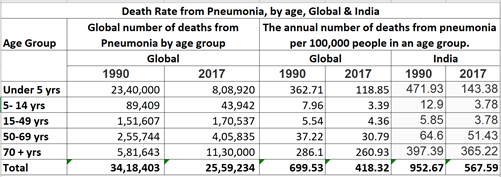


 One of the major challenges that medical professionals face is the correct diagnosis of pneumonia condition in a patient, which is a preventable and curable disease.
 Not being able to correctly diagnose the condition is a problem for both the patient and the doctor. If the doctor misdiagnoses the patient it could lead to malpractice lawsuits and overall hurt the doctor’s practice. 
- In case the pneumonia is undetected the patient suffers by not receiving the proper treatment and risking greater harm to health by the condition that goes undetected.
- On the other hand, wrong diagnoses lead to overdiagnosis of pneumonia and overuse of antibiotics and contributes to drug resistance, costs the patient time & money, increases health system costs and unnecessarily exposes patients to drug side effects.

Given that, there is acute need to assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology) or where there is shortage of trained professionals in certain parts of world who can read and interpret x-rays, the potential for automated diagnosis based on a patient’s chest x-ray is undoubtedly high.

Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.
In this project we look at how best we can automate Pneumonia screening in chest radiographs and identify whether the patient is having pneumonia or the condition is normal by localization around areas of the lung opacities.. 

We propose to achieve this by Deep Neural Networks(DNNs) by providing pneumonia affected area details through bounding box and assist the Doctors take right path of treatment to reduce the number of people dying from this disease.

Additionally, when doctor faces clinical suspicion of pneumonia with perhaps some radiographic confirmation but that may be borderline or may not be pneumonia. Under such circumstances the DNN results would certainly be a Godsend.

Radiologists are highly paid and with implementation like pneumonia detection system the cost could be reduced.

**The above facts justiy the business need for developing an effiecient diganosis and cost saving automated Pneumonia Detection System in the field of Health Technology Services.**





## What is pneumonia?

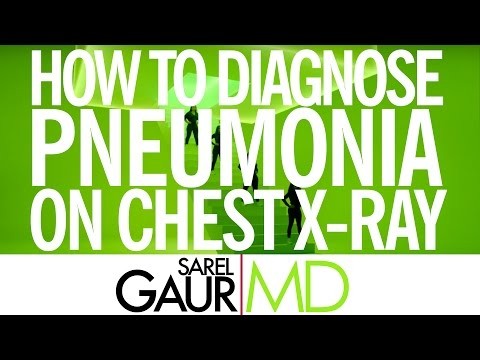

In [1]:
import IPython
IPython.display.YouTubeVideo('mMEen0O6xwc')

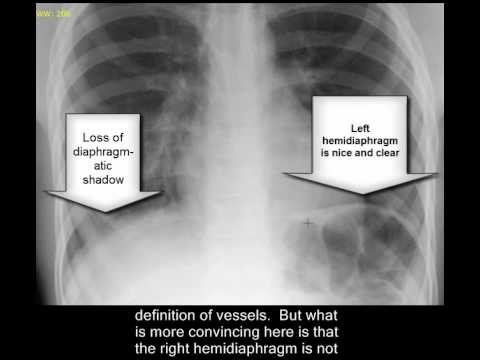

In [2]:
IPython.display.YouTubeVideo('o5czh4JM0Ho')

**Importing the Libraries(classes and functions)**

In [3]:
import tensorflow
print('TensorFlow Version', tensorflow.__version__)
from IPython.display import Markdown, display           # To make print text in bold

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd 
# import pandas.testing as tm
import seaborn as sns
# import IPython
# import glob

import os

import warnings
warnings.filterwarnings("ignore")

TensorFlow Version 2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def printmd(string):
    display(Markdown(string))

## Loading and Preparing the Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFcpxfGvYnHn_8pO6XoOQP-Jde4cTarbPgBJ_OxYRnj9Z34rQgdL7M
Mounted at /content/drive


In [6]:
import os
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

In [7]:
!ls

 full_model.h5			        model_basic_cnn.pkl
'GCP Credits Request Link - RSNA.txt'   model.png
 generated_data			        stage_2_detailed_class_info.csv
 image_bbox_full.csv		        stage_2_sample_submission.csv
 lung_opacity_weights.best.hdf5         stage_2_test_images
 meta_data.pkl			        stage_2_train_images
 model_basic_cnn.h5		        stage_2_train_labels.csv


In [8]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_class_info = pd.read_csv('stage_2_detailed_class_info.csv')

In [9]:
pd_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
y0 = pd_label[(pd_label['Target']==0)].Target.count()
y1 = pd_label[(pd_label['Target']!=0)].Target.count()
printmd('**Number of patient records(including multiple records for a patientid) available in the training dataset(1) are: {}**'.format(pd_label.shape[0]))
printmd('**Number of unique patientIds available in the training dataset(1) are: {}**'.format(pd_label.patientId.value_counts().shape[0]))
printmd('**Number of patientIds marked as pneumonia Negative are: {}**'.format(y0))
printmd('**Number of patientIds marked as pneumonia positive are: {}**'.format(y1))

**Number of patient records(including multiple records for a patientid) available in the training dataset(1) are: 30227**

**Number of unique patientIds available in the training dataset(1) are: 26684**

**Number of patientIds marked as pneumonia Negative are: 20672**

**Number of patientIds marked as pneumonia positive are: 9555**

- There are some patient ids for which there are no bounding box as evident from the above dataframe. 
- There are some patient ids for which multiple records are available indicating more than one bounding boxes and hence number of unique patient ids are 26684(less than total records of 30227). 

In [11]:
null_df = pd.DataFrame(pd_label.apply(lambda x: sum(x.isnull())))
null_df.columns = ['Number of Null']
null_df.T

,patientId,x,y,width,height,Target
Number of Null,0,20672,20672,20672,20672,0


In [12]:
notnull_df = pd.DataFrame(pd_label.apply(lambda x: sum(x.notnull())))
notnull_df.columns = ['Number of Not-Null']
notnull_df.T

,patientId,x,y,width,height,Target
Number of Not-Null,30227,9555,9555,9555,9555,30227


- Out of 30227 patient records 20672 records do not have bounding box details
- Out of 30227 patient records 9555 records have bounding box details.

In [13]:
No_Bnd_Box_df = pd_label[(pd_label['x'].isnull()) & (pd_label['y'].isnull()) & (pd_label['width'].isnull()) & (pd_label['height'].isnull())]
No_Bnd_Box_df[(No_Bnd_Box_df['Target']==0)].count()

patientId    20672
x                0
y                0
width            0
height           0
Target       20672
dtype: int64

- For 20672  patient records for which the bounding box details are not available the target variable is 0 indicating these are the patients who do not have pneomonia.

In [14]:
Bnd_Box_df = pd_label[(pd_label['x'].notnull()) & (pd_label['y'].notnull()) & (pd_label['width'].notnull()) & (pd_label['height'].notnull())]
Bnd_Box_df[(Bnd_Box_df['Target']==1)].count()

patientId    9555
x            9555
y            9555
width        9555
height       9555
Target       9555
dtype: int64

- For the 9555 patients where the bounding box details are available the target variable is 1 indicating these are patient records marked as having pneumonia.
- We can conclude that:
 - Where there are no bounding boxes for the patient the target varaiable is 0. 
 - For all the patientids for which the bounding box is available the target variable is 1. 

In [15]:
Bnd_Box_df.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [16]:
printmd('**Number of patients with No Bounding Box: {}**'.format(No_Bnd_Box_df['Target'].count()))
printmd('**Distribution of Number of Bounding Boxes**')
bboxCnt = Bnd_Box_df.groupby("patientId").size().reset_index(name="BboxCnt")
bboxCnt.groupby('BboxCnt').size().reset_index(name='Patient_Counts')

**Number of patients with No Bounding Box: 20672**

**Distribution of Number of Bounding Boxes**

,BboxCnt,Patient_Counts
0,1,2614
1,2,3266
2,3,119
3,4,13


- The number of peumonia patients having two bounding box is maximum at 3266 and having 4 bounding box is least at 13. 
- The countplot is presented below.

In [17]:
pd_bboxCnt_pnm = pd.merge(Bnd_Box_df,bboxCnt,on='patientId')
pd_bboxCnt_pnm.head()

,patientId,x,y,width,height,Target,BboxCnt
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,2
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,2
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,2


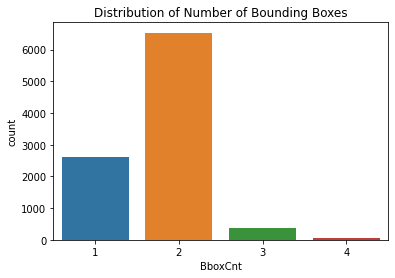

In [18]:
 ax = sns.countplot(pd_bboxCnt_pnm['BboxCnt']);   
_ = ax.set_title('Distribution of Number of Bounding Boxes')   

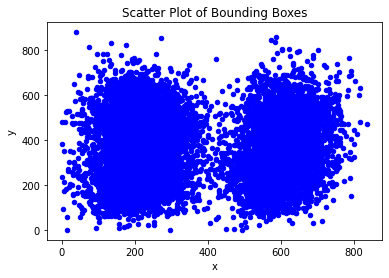

In [19]:
pos_bbox = pd_bboxCnt_pnm.query('Target==1')
ax1= pos_bbox.plot.scatter(x='x', y='y', c=np.array(['blue']));
_ = ax1.set_title('Scatter Plot of Bounding Boxes')   

- The above plot indicates there are less bounding boxes in the periphery and clustering more in the Right lungs. 

In [20]:
pd_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


- The data type of patientid is obviously an object, the coordinates, width and height of bounding box are float64 and finally the binary target is int64.

In [21]:
pd_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


- For the first 3 patientIds the 'No Lung Opacity / Not Normal class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and often times this finding may mimic the appearance of true pneumonia. 
- For the patientid 3 the class is normal case where there are no lung opacities. 
- For the patientid 4 the class is Lung Opacity which is marked as such for patients who are identified to have pneumonia.

In [22]:
printmd('**Number of patient records(including multiple records for a patientid) available in the training dataset(2) are: {}**'.format(pd_class_info.shape[0]))
printmd('**Number of unique patientIds available in the training dataset(2) are: {}**'.format(pd_class_info.patientId.value_counts().shape[0]))

**Number of patient records(including multiple records for a patientid) available in the training dataset(2) are: 30227**

**Number of unique patientIds available in the training dataset(2) are: 26684**

In [23]:
pd_class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [24]:
print(pd_class_info['class'].unique())

['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


In [25]:
printmd('**Lung Opacity Distribution**')
print(pd_class_info['class'].value_counts())

**Lung Opacity Distribution**

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


In [26]:
#Let us concatenate to create a merged Training dataset.
pd_pnm = pd.concat([pd_label,pd_class_info.drop('patientId',1)],1)
pd_pnm.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [27]:
dupes = pd_pnm.duplicated()
sum(dupes)

0

- There are no duplicate records. However, for one patientid there can be more than one records containing different bounding box details.

### Visualize Target & class

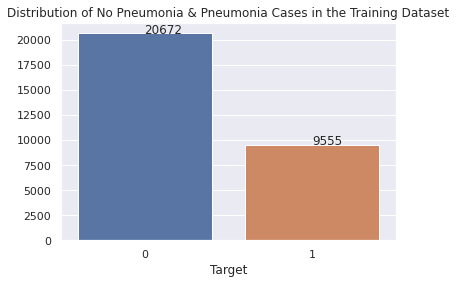

In [28]:
sns.set(rc={'figure.figsize':(6,4)})
plt.title('Distribution of No Pneumonia & Pneumonia Cases in the Training Dataset')
target = pd_pnm.groupby('Target').size()
g = sns.barplot(x=target.index, y=target.array)
x = 0.0
for val in target.array:
  g.text(x=x,y=val+2,s=val)
  x=x+1

- The Target variable is imbalanced and requires to be balanced for better model performance. The team will be taking up the in this second phase of the project.

In [29]:
classlabel = pd_pnm.groupby('class').size()

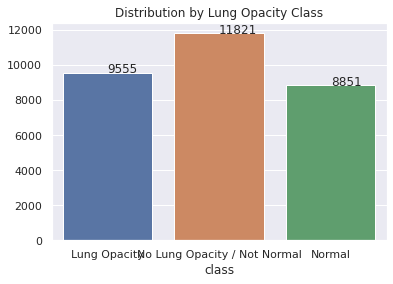

In [30]:
sns.set(rc={'figure.figsize':(6,4)})
plt.title('Distribution by Lung Opacity Class')
g = sns.barplot(x=classlabel.index, y=classlabel.array)
x = 0.0
for val in classlabel.array:
  g.text(x=x,y=val+2,s=val)
  x=x+1

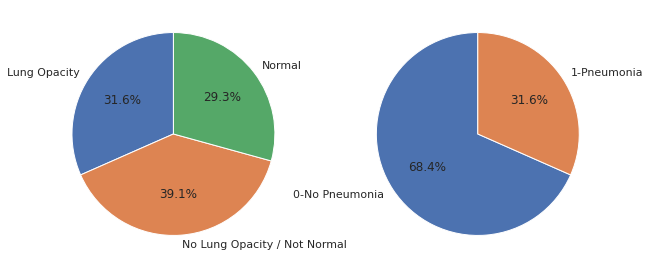

In [31]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2, figsize=(10,7))
unique_values, count = np.unique(pd_pnm['class'], return_counts=True)
ax[0].pie(count, labels = ['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
          autopct='%1.1f%%', startangle=90)
unique_values, count = np.unique(pd_pnm['Target'], return_counts=True)
ax[1].pie(count, labels = ['0-No Pneumonia', '1-Pneumonia'],
          autopct='%1.1f%%', startangle=90)
plt.show()


Observation: Class imbalance in final target label(68% vs 31%) Whereas 'class'  feature is well distributed.  

**Bivariate Analysis of Lung Opacity Classes and Target Variable**

                          class  Target  Patient_Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851


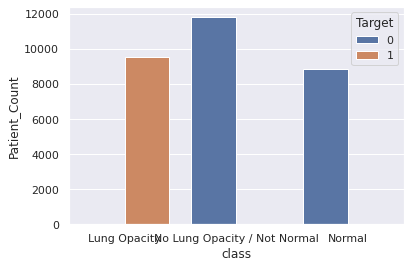

In [32]:
#Lets check how  each class(3) is distributed among each target(0,1))
class_target = pd_pnm.groupby(['class','Target']).size().reset_index(name='Patient_Count')
printmd('**Bivariate Analysis of Lung Opacity Classes and Target Variable**')
print(class_target.head())
# class_target['class']
sns.set(rc={'figure.figsize':(6,4)})
sns.barplot(x="class",y ="Patient_Count",hue='Target',data=class_target);

- There are 11821 No Lung Opacity/Not Normal patientIds and 8851 patientIds wherein the Target variable is 0.
- There are 9555 patient records with Lung Opacity with Target variable as 1.

### Study CXR image

  @TODO Describe how dicom files are stored

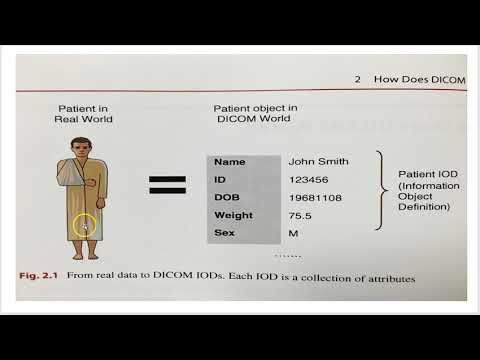

In [33]:
IPython.display.YouTubeVideo('eCECXr-HxVs')

In [34]:
pip install pydicom

     |████████████████████████████████| 35.5MB 89kB/s 


In [35]:
#Let concatenate to create a merged data set.
pd_pnm = pd.concat([pd_label,pd_class_info.drop('patientId',1)],1)

In [36]:
#Lets check how many bounding boxes for each patients 
#Even if bouding boxes is NaN, it is counted here.
bbox = pd_pnm.groupby("patientId").size().reset_index(name="BboxNo")
bbox.groupby('BboxNo').size().reset_index(name='Patient Count')

,BboxNo,Patient Count
0,1,23286
1,2,3266
2,3,119
3,4,13


                          class  Target  Patient_Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851


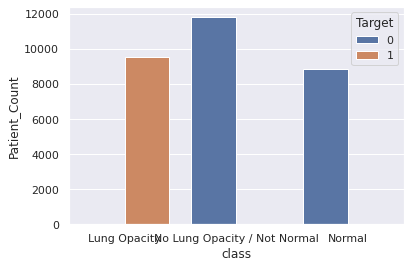

In [37]:
#Lets check how  each class(3) is distributed among each target(0,1))
class_target = pd_pnm.groupby(['class','Target']).size().reset_index(name='Patient_Count')
print(class_target.head())
# class_target['class']
sns.barplot(x="class",y ="Patient_Count",hue='Target',data=class_target)

In [38]:
import pydicom
import pickle

In [39]:
%%time
#Collect all dicom files
# import glob

gen_data_dir = 'generated_data'
dcm_files = gen_data_dir + '/dcm_file_list.pkl'
if not os.path.exists(gen_data_dir):
  os.makedirs(gen_data_dir)

train_dcms = []
test_dcms = []
if (os.path.isfile(dcm_files) == False):
  print('Generating train/test dcm filelist')
  xray_train_folder = 'stage_2_train_images'
  xray_test_folder = 'stage_2_test_images'
  train_dcms = os.listdir(xray_train_folder)
  test_dcms = os.listdir(xray_test_folder)
  for i, f in enumerate(train_dcms):
    train_dcms[i] = xray_train_folder+'/'+f
  for i, f in enumerate(test_dcms):
    test_dcms[i] = xray_test_folder+'/'+f
  a_file = open(dcm_files, "wb")
  all_files = {"train":train_dcms,"test":test_dcms}
  pickle.dump(all_files, a_file)
  a_file.close()
else:
  print('Loading train/test files')
  a_file = open(dcm_files, "rb")
  all_files = pickle.load(a_file)
  train_dcms = all_files['train']
  test_dcms = all_files['test']
  a_file.close()





Loading train/test files
CPU times: user 8.96 ms, sys: 1.01 ms, total: 9.97 ms
Wall time: 991 ms


In [40]:
printmd("**Number of Train Images:{}, Number of Test Images:{}**".format(len(train_dcms),len(test_dcms)))
train_dcms[0]

**Number of Train Images:26684, Number of Test Images:3000**

'stage_2_train_images/f6ba1426-6cf9-42a8-ab35-ab0dcead78e2.dcm'

In [43]:
printmd('**Sample Image metadata Details**')
dataset = pydicom.dcmread(train_dcms[0])
print(dataset)

**Sample Image metadata Details**

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.23189.1517874446.140912
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.23189.1517874446.140912
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [44]:
printmd('**Keywords in metadata**')
for d in dataset:
  pass
for t ,e in dataset.items():
  print("keyword =",e.keyword)

**Keywords in metadata**

keyword = SpecificCharacterSet
keyword = SOPClassUID
keyword = SOPInstanceUID
keyword = StudyDate
keyword = StudyTime
keyword = AccessionNumber
keyword = Modality
keyword = ConversionType
keyword = ReferringPhysicianName
keyword = SeriesDescription
keyword = PatientName
keyword = PatientID
keyword = PatientBirthDate
keyword = PatientSex
keyword = PatientAge
keyword = BodyPartExamined
keyword = ViewPosition
keyword = StudyInstanceUID
keyword = SeriesInstanceUID
keyword = StudyID
keyword = SeriesNumber
keyword = InstanceNumber
keyword = PatientOrientation
keyword = SamplesPerPixel
keyword = PhotometricInterpretation
keyword = Rows
keyword = Columns
keyword = PixelSpacing
keyword = BitsAllocated
keyword = BitsStored
keyword = HighBit
keyword = PixelRepresentation
keyword = LossyImageCompression
keyword = LossyImageCompressionMethod
keyword = PixelData


In [45]:
# All the patients from dcm files list
patiendIDs = [os.path.basename(img).split('.')[0] for img in train_dcms]
len(patiendIDs)
patiendIDs[0]

'f6ba1426-6cf9-42a8-ab35-ab0dcead78e2'

In [46]:
#create a datafram of patientID & path. This will be merged with bounding box dataset
df_image = pd.DataFrame({"patientId":patiendIDs,"path":train_dcms})

In [47]:

df_image.sample(5)

,patientId,path
10151,a1e46713-1cd9-4360-9a3f-5e57e418c5a2,stage_2_train_images/a1e46713-1cd9-4360-9a3f-5...
3569,e3a261d3-0cfe-4e75-ab0b-1dfd45a9991b,stage_2_train_images/e3a261d3-0cfe-4e75-ab0b-1...
2913,ee05c3bf-cadf-4aa4-85cb-d8f52608fb44,stage_2_train_images/ee05c3bf-cadf-4aa4-85cb-d...
23324,3168b733-12d4-475e-8789-8c8b230743c4,stage_2_train_images/3168b733-12d4-475e-8789-8...
6125,c4b66f86-ea11-4db3-a121-40893a8538e9,stage_2_train_images/c4b66f86-ea11-4db3-a121-4...


In [48]:
#Merge merge bounding box dataset with image dataset
# first merge pd_pnm with bbox dataset
pd_bbox_pnm = pd.merge(pd_pnm,bbox,on='patientId')
df_final = pd.merge(pd_bbox_pnm,df_image,on='patientId',how='left')
print(df_final.shape[0])
df_final.head(6)

30227


,patientId,x,y,width,height,Target,class,BboxNo,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...


In [49]:
def xray(filename):
  dataset = pydicom.dcmread(filename)
  
  # print(type(dataset))
  print()
  print("Filename.........:", filename)
  print("Storage type.....:", dataset.SOPClassUID)
  print()

  pat_name = dataset.PatientName
  display_name = pat_name.family_name + ", " + pat_name.given_name
  print("Patient's name...:", display_name)
  print("Patient id.......:", dataset.PatientID)
  print("Modality.........:", dataset.Modality)
  print("Study Date.......:", dataset.StudyDate)
  print("Study Date.......:", dataset.StudyDate)
  print("Patient Sex......:",dataset.PatientSex)
  print("Patient Age......:",dataset.PatientAge)
  print("Patient Body Part:",dataset.BodyPartExamined)
  print("Patient View Posi:",dataset.ViewPosition)
  if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

  
  print("Slice location...:", dataset.get('SliceLocation', "(missing)"))
  image = dataset.pixel_array
  print(type(image),image.dtype,image.shape)
  plt.axis('off')
  plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
  plt.show()

- The above utility functions is for calling important metadata and image of a patient by passing the file path.
- The below utility function is written to draw the same metadata and image of a patient by passing the index of record.

In [50]:
def showXray(row):
  rw = df_final.iloc[row]
  patID = rw.patientId
  dicomfile = rw.path
  title = rw['class']
  plt.title(title)
  xray(dicomfile)



Filename.........: stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id.......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: F
Patient Age......: 51
Patient Body Part: CHEST
Patient View Posi: PA
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)
<class 'numpy.ndarray'> uint8 (1024, 1024)


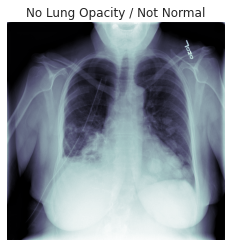

In [51]:
#Lets see xray for Not Normal but no Pneumonia case
showXray(0)


Filename.........: stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, 
Patient id.......: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: M
Patient Age......: 28
Patient Body Part: CHEST
Patient View Posi: PA
Image size.......: 1024 x 1024, 155284 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)
<class 'numpy.ndarray'> uint8 (1024, 1024)


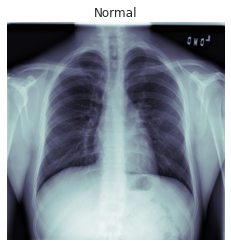

In [52]:
#Lets observe absolutely Normal & no Pneumonia case
showXray(3)


Filename.........: stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 00436515-870c-4b36-a041-de91049b9ab4, 
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: F
Patient Age......: 32
Patient Body Part: CHEST
Patient View Posi: AP
Image size.......: 1024 x 1024, 119382 bytes
Pixel spacing....: [0.139, 0.139]
Slice location...: (missing)
<class 'numpy.ndarray'> uint8 (1024, 1024)


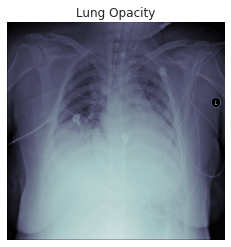

In [53]:
#Lets observe Lung Opacity & hence Pneumonia case
showXray(4)

### Show the bounding box
All xray does not have bounding box.
There are maximum of 4 bounding box for a given x-ray

In [54]:
df_pneumonia = df_final[df_final.Target == 1]
df_pneumonia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  9555 non-null   object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     9555 non-null   int64  
 6   class      9555 non-null   object 
 7   BboxNo     9555 non-null   int64  
 8   path       9555 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 746.5+ KB


In [55]:
patients = set(df_pneumonia.patientId)
print("Unique patients :",len(patients))

Unique patients : 6012


In [56]:
def get_bbox_map(df_pn):
  bbox_map = {}
  for n, row in df_pn.iterrows():
    pid = row['patientId']
    if pid not in bbox_map:
      bbox_map[row.patientId] = {'path':row['path'], "bboxes":[] }
    bbox_map[pid]['bboxes'].append([int(float(row['y'])), int(float(row['x'])),
                                    int(float(row['height'])), int(float(row['width']))])
  return bbox_map

- The function maps bounding boxes for a pateintId by appending if there are more than one bounding boxes.

In [57]:
# FULL train patinets with bounding boxes
bbox_map = get_bbox_map(df_pneumonia)

print(bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'])
# bb = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('bboxes')
# print(bb)
# for i in bb:
#   for j in i:
#     print(type(j))

{'path': 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm', 'bboxes': [[318, 316, 478, 170], [375, 660, 402, 146]]}


In [58]:
#Patient with 2 bounding box
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('bboxes')


[[318, 316, 478, 170], [375, 660, 402, 146]]

In [59]:
#Reduced data set for training.
#get bbox_map for ceratain % as training time is very high
df_final_reduce = df_final.sample(frac=0.03,random_state=11)
bbox_map_reduce = get_bbox_map(df_final_reduce[df_final_reduce.Target == 1])

In [60]:
print(df_final_reduce.info())
print("No of pneomonia case:",len(bbox_map_reduce))
patient = np.array(df_final_reduce[df_final_reduce.Target == 1].sample().patientId)[0]
print('patient:',patient)
bb = bbox_map_reduce[patient].get('bboxes')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 907 entries, 25472 to 29548
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  907 non-null    object 
 1   x          307 non-null    float64
 2   y          307 non-null    float64
 3   width      307 non-null    float64
 4   height     307 non-null    float64
 5   Target     907 non-null    int64  
 6   class      907 non-null    object 
 7   BboxNo     907 non-null    int64  
 8   path       907 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 70.9+ KB
None
No of pneomonia case: 304
patient: 390dad2f-bd13-4f16-92af-4e061499eddc


In [61]:
def drawbbox(pid):
  dcm = pydicom.read_file(pid.get('path'))
  pixel = dcm.pixel_array
  pixel = np.stack([pixel] * 3, axis=2) #Convert into 3 channel
  for box in pid['bboxes']:
    box = [int(b) for b in box]
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width
    rgb = np.floor(np.random.rand(3) * 256).astype('int')
    # print(rgb)
    stroke = 6
    pixel[y1:y1 + stroke, x1:x2] = rgb
    pixel[y2:y2 + stroke, x1:x2] = rgb
    pixel[y1:y2, x1:x1 + stroke] = rgb
    pixel[y1:y2, x2:x2 + stroke] = rgb
  plt.imshow(pixel, cmap=plt.cm.gist_gray)
  plt.axis('off')

- The drawbbox function superimposes the bounding box/boxes on the relevant patient image based on the mapping. 
- Sample images with two and four bounding boxes is shown below.

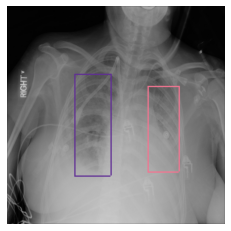

In [62]:
drawbbox(bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'])

In [63]:
#Find patients having bounding box =4
set(df_pneumonia[df_pneumonia.BboxNo == 4].patientId[:6])


{'0ab261f9-4eb5-42ab-a9a5-e918904d6356',
 '0d5bc737-03de-4bb8-98a1-45b7180c3e0f'}

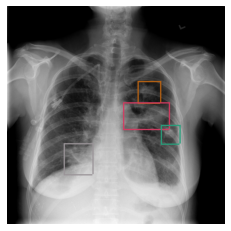

In [64]:
#Draw a sample  patient with 4 bounding box
drawbbox(bbox_map['0ab261f9-4eb5-42ab-a9a5-e918904d6356'])

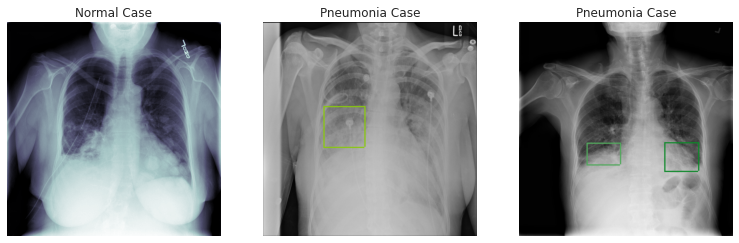

In [65]:
plt.figure(figsize=(13, 13))
plt.subplot(1, 3, 1)
plt.title("Normal Case")
im =pydicom.dcmread('stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm')
plt.imshow(im.pixel_array, cmap=plt.cm.bone);
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Pneumonia Case")
drawbbox(bbox_map['f76c9846-d88a-4d7c-b887-2759a4333f7c'])
#plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Pneumonia Case")
drawbbox(bbox_map['00704310-78a8-4b38-8475-49f4573b2dbb'])

- Usually the lungs are full of air and ideally the CXR should be more black. 
- When someone has pneumonia, the air in the lungs is replaced by other material - fluids, bacteria, immune system cells, etc. 
- Hence, the areas of opacities are areas that are grey instead of black.
- When we see the area in the bounding boxes we understand that the lung tissue in that area is probably not healthy.
- In the first image we can see clear black lungs and in the second and third images there is fuzziness due to opacity.

### Handling missing bounding box

In [66]:
#Check if there is any Target(non-pneumonia case) with bounding box
df_final[(np.isnan(df_final.x) == False) & (df_final.Target == 0)]

,patientId,x,y,width,height,Target,class,BboxNo,path


So there is no data having bounding box but it is not pneumonia case.

### Metadata Analysis
Lets check if meta data in dcm like age, sex, viewposition etc
 have any  significant information for predicting "Target" binary class.

In [67]:
#lets collect meta data & save it in dataframe & save in a file for futute use.
%%time
import gc


def collectMetaData(df_meta):
  dcm_columns = None

  for n, pid in enumerate(df_meta['patientId'].unique()):
      if n%1000==0:
          print(n,len(df_meta['patientId'].unique()))
      dcm_file = './stage_2_train_images/%s.dcm' % pid
      dcm_data = pydicom.read_file(dcm_file)
      
      if not dcm_columns:
          dcm_columns = dcm_data.dir()
          dcm_columns.remove('PixelSpacing')
          dcm_columns.remove('PixelData')
      
      for col in dcm_columns:
          if not (col in df_meta.columns):
              df_meta[col] = np.nan
          index = df_meta[df_meta['patientId'] == pid].index
          df_meta.loc[index, col] = dcm_data.data_element(col).value
          
      del dcm_data
    


CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 14.1 µs


In [68]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1rolp8QqyKkvxJwlBAPPGtG2f3JA7hMwk"})

In [70]:
meta_file = 'meta_data.pkl'

df_meta = pd.DataFrame()
if (os.path.isfile(meta_file)):
  print("Loading saved meta data")
  df_meta =pd.read_pickle(meta_file)
  # gc.collect()
else:
  printf("Loading meta data from google drive")
  downloaded.GetContentFile(meta_file)
  df_meta =df.read_pickle(meta_file)
  # df_meta = df_final.drop('class', axis = 1).copy()
  # collectMetaData(df_meta)
  # df_meta.to_pickle(meta_file)
  

Loading saved meta data


In [71]:
df_meta.head(1)

,patientId,x,y,width,height,Target,BboxNo,path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,Modality,PatientAge,PatientBirthDate,PatientID,PatientName,PatientOrientation,PatientSex,PhotometricInterpretation,PixelRepresentation,ReferringPhysicianName,Rows,SOPClassUID,SOPInstanceUID,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,,8.0,8.0,CHEST,1024.0,WSD,7.0,1.0,01,ISO_10918_1,CR,51,,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,,F,MONOCHROME2,0.0,,1024.0,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.28530.15178744...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA


In [72]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patientId                    30227 non-null  object 
 1   x                            9555 non-null   float64
 2   y                            9555 non-null   float64
 3   width                        9555 non-null   float64
 4   height                       9555 non-null   float64
 5   Target                       30227 non-null  int64  
 6   BboxNo                       30227 non-null  int64  
 7   path                         30227 non-null  object 
 8   AccessionNumber              30227 non-null  object 
 9   BitsAllocated                30227 non-null  float64
 10  BitsStored                   30227 non-null  float64
 11  BodyPartExamined             30227 non-null  object 
 12  Columns                      30227 non-null  float64
 13  ConversionType  

In [73]:
to_drop = df_meta.nunique()
to_drop = to_drop[(to_drop <= 1) | (to_drop == to_drop['patientId'])].index
to_drop = to_drop.drop('patientId')
df_meta.drop(to_drop, axis = 1, inplace = True)
df_meta.head(1)

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,SeriesDescription,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,F,view: PA,PA


In [74]:
df_meta['PatientAge'] = df_meta['PatientAge'].astype(int)
df_meta['SeriesDescription'] = df_meta['SeriesDescription'].map({'view: AP': 'AP', 'view: PA': 'PA'})

df_meta.drop('SeriesDescription', axis = 1, inplace = True)

df_meta['PatientSex'] = df_meta['PatientSex'].map({'F': 0, 'M': 1})
df_meta['ViewPosition'] = df_meta['ViewPosition'].map({'PA': 0, 'AP': 1})

In [75]:
df_meta.head()

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19,1,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28,1,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,32,0,1


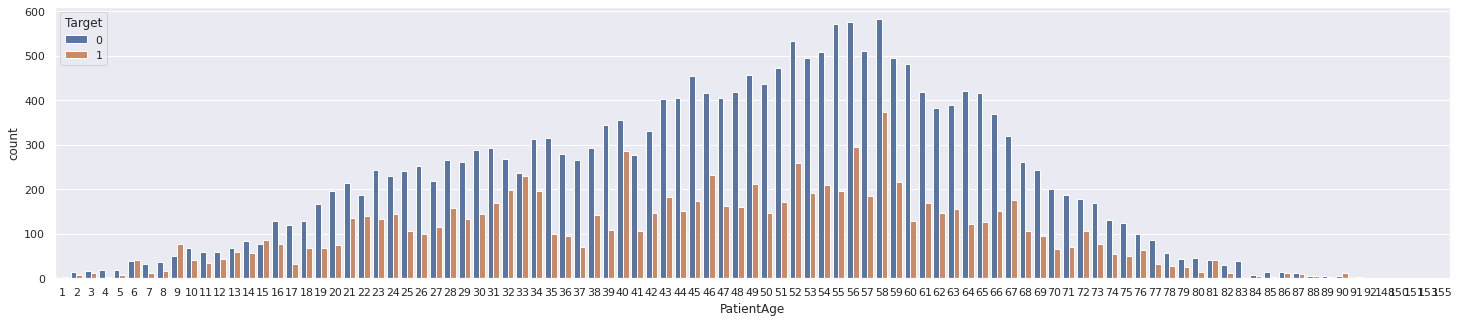

In [76]:
plt.figure(figsize = (25, 5))
sns.countplot(x = 'PatientAge', hue = 'Target', data = df_meta)
plt.show()

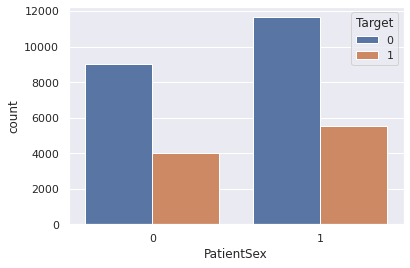

In [77]:
sns.countplot(x = 'PatientSex', hue = 'Target', data = df_meta)

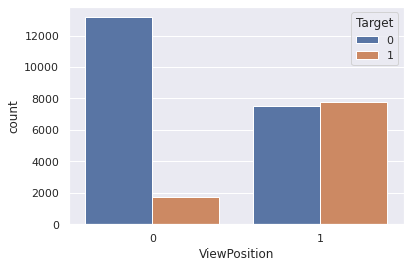

In [78]:
sns.countplot(x = 'ViewPosition', hue = 'Target', data = df_meta)

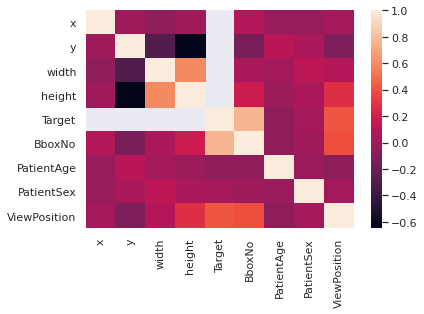

In [79]:
sns.heatmap(df_meta.corr())

Viewposition have highest corelation with target folwed by sex, then age.


In [80]:
#Try predicing "Target" using this meta data 
def fast_lgbm_cv_scores(df, target, task, rs = 0):
    
    clf = LGBMClassifier(n_estimators = 10000, nthread = 4, random_state = rs)
    metric = 'auc'

    # Cross validation model
    folds = KFold(n_splits = 2, shuffle = True, random_state = rs)
        
    # Create arrays and dataframes to store results
    pred = np.zeros(df.shape[0])
    
    feats = df.columns.drop(target)
    
    feature_importance_df = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[target])):
        train_x, train_y = df[feats].iloc[train_idx], df[target].iloc[train_idx]
        valid_x, valid_y = df[feats].iloc[valid_idx], df[target].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(valid_x, valid_y)], eval_metric = metric, 
                verbose = -1, early_stopping_rounds = 100)

        pred[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        feature_importance_df[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    return feature_importance_df, pred, roc_auc_score(df[target], pred)

In [81]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

f_imp, _, score = fast_lgbm_cv_scores(df_meta.drop(['patientId', 'x', 'y', 'width', 'height','BboxNo'], axis = 1), 
                                      target = 'Target', task = 'classification')
print('ROC-AUC for Target = {}'.format(score))

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[37]	valid_0's auc: 0.751919	valid_0's binary_logloss: 0.528533
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's auc: 0.756999	valid_0's binary_logloss: 0.522433
ROC-AUC for Target = 0.7544078663854205


In [82]:
f_imp

,0,1
PatientAge,931,1069
PatientSex,142,120
ViewPosition,37,41


**Prediction based on meta data shows high 75% which means "Target" will be predicted with high confidence.**
**Also important features are PatientAge, PatientSex, ViewPosition"**



## EDA Conclusion
 As can be expected, there is a direct correlation between the Target and Class
parameters. The only difference is that Target is a binary classification and we
would find an unbalanced distribution between both possibilities, as opposed to
Class where the category "No" is subdivided into the categories "Normal" and "No
Lung Opacity / Not normal".

 In the parameters Sex and View we see a slightly higher distribution of men and
catches with PA view. But the difference is not significant.

 In the parameter of age, we see that the dataset corresponds to an adult population
reaching old age, with few samples in the earliest ages.

**Based on this finding we will come up with two below architectural decision.**

## Model Building


### Proposed Implementation Architeture
So to determine if the given xray has any pneumonia characteristics or opacity & locating the problamatic location in the xray, we can approach the problem in either of the below options.

Option 1:
  1. Given any xray build basic CNN model which can try to find any inherent pattern for target class(normal, not-normal, opage) without any bounding box. This is like **object recognition with classification**. This result is used along with metadata to find the target.
  2. Detection of bounding box using various **Object recognition with localization** algorithms if the image has any pneominia. Also use **Object detection** technique incase there is multiple location of pneumonia in given xray.
  Advantage with this approach is that we will be using balanced target first (29%,39%,31%) & this result will be used with meta data to do final classification. In detection part we will be using only pnemonia cases. This will lead to lower training time as we will be dealing with lesser data set.


  
**Below is an high level architecture of proposed implementation of option 1.**

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/General_flow_chart_proposed%20implementation.PNG)

As you can see there are 3 major module. Each of them gets executed sequentially.
1. **Pre-Processing module**: In this layer, metadat is extracted out from dicom file & if required black border also will be removed. Pre-Processed dicom image  (1024x1024) is passed to  both classification & detection module. Classificattin module also takes metadata extracted from dicom file + data (x,y,width,height) for final classification(if required).

2. **Classification module**: This module specialized exclusively in image classification. The output of the module shall consist of a single probability value between 0 and 1 of the presence or non-presence of pneumonia globally, i.e. as a function of the entire
image as a whole. In the first place, this module will allow us to globally categorize the sample in 2 classes: image with case of pneumonia and image free of any trace of pneumonia and secondly its output can directly influence the predictions obtained
in the detection module.
3. **Detection module**: This module specialized in the task of object detection. The result of this module will be a list of vectors where each one of them defines a bounding box detected. Each bounding box will be defined by 5 elements which are x1,y1, x2, y2 and confident score. The first 4 elements make up the coordinates that delimit the box detected and the last element, confidence score, defines the
probability that this box frames an area of pneumonia.

Option 2:

  Predicting target & bounding box directly using deep neural network(DNN) . For example **image segmentation** algorithm like "Mask R-CNN" to show pixels which belong to pneumonia opacity symtoms. The problem with this approach is that data is imbalanced (68% vs 32%). This can lead to low recall value which is of prime importance to this pneumonia detection problem.
  ![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/Segmentation.PNG)



### Training and Prediction Strategies:
  1. Both classification & detection module will have mainly Convolution Neural Network(CNN). Classification stage final model will have Feed Forward Neural Network(FFNN).
  2. In the modules of classification and detection we are trying  to maximize the objective metric for which we have applied techniques of combination of multiple predictions for each model and more than one model in a weighted way.

  3. The dataset used is composed of DICOM format files and their corresponding annotations/meta data will be divided into 3 portions: **train, validation and test**. In the training process we will use only the training and validation portions. Test set will be reserved to evaluate the trained models and in the processes of combination of
predictions and models.

Below figure shows the workflow of the training process. In this process only the training
and validation subsets act. After each epoch the current model will be evaluated using
the validation set looking for optimal values of bias and variance. In both the training
and detection modules we will train multiple models.

  ![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/Training_process.PNG)

### Metric for classification & detection module
We will be using the [*IOU & Precision Value*](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/evaluation) metric for detection module & classification module.

### Basic CNN Segmentation(Option-2)
We will start with option 2. And we will start with simple CNN model training with dicom pixel array & try to understand the performance we are getting. This will be base refernce performance model. 
 We can then modify the layers and the activation functions to understand the effect they have on the performance. But, going by the typical computer vision solutions, it's highly unlikely that we will get excellent results from the shallow network. That's why, we will next shift to transfer learning using pre-trained models like VGG-16, VGG-19, UNET and then to even more advanced networks like Mask-RCNN and YOLOv3/4. But, in the interim report, we will focus primarily on training a shallow CNN model and using VGG models for transfer learning.



In [83]:
# Data generation
import gc
print("Unique patients:",len(bbox_map))
print("Unique reduce patients:",len(bbox_map_reduce))
print(pd.DataFrame(bbox_map).T.sample(5))
gc.collect()

Unique patients: 6012
Unique reduce patients: 304
                                                                                   path                                        bboxes
87e4af8b-1110-481d-86de-f315ca03936d  stage_2_train_images/87e4af8b-1110-481d-86de-f...                        [[328, 267, 309, 310]]
7ebeb647-d104-412c-a202-247b650f7cc0  stage_2_train_images/7ebeb647-d104-412c-a202-2...  [[445, 632, 254, 200], [463, 185, 274, 254]]
36898db8-3570-4740-a396-aaf6cee6b7a1  stage_2_train_images/36898db8-3570-4740-a396-a...  [[332, 579, 483, 235], [383, 135, 332, 296]]
b7734503-5808-403e-96d7-5ea55a96a1a3  stage_2_train_images/b7734503-5808-403e-96d7-5...  [[259, 187, 294, 240], [245, 591, 339, 247]]
97cd19cb-73b1-47df-b60f-380d44fc0ec9  stage_2_train_images/97cd19cb-73b1-47df-b60f-3...                        [[371, 115, 237, 290]]


11

#### Train-valid-test spliting

In [84]:
#Partition on original image
# partition train images(train_dcms) into 3 categories. 1. training(70%), 2. Validation(15%) 3. test(15%)
def split_sample(dcms):
  np.random.shuffle(dcms)
  no_train_sample_index = int(len(dcms) *(0.7))
  no_valid_sample_index = int(len(dcms)* (0.85))
  train_filenames = dcms[:no_train_sample_index]
  valid_filenames = dcms[no_train_sample_index:no_valid_sample_index]
  test_filesnames = dcms[no_valid_sample_index:]
  print('training samples:', len(train_filenames))
  print('validation samples:', len(valid_filenames))
  print('test samples:',len(test_filesnames))
  print('Total dcm files:',len(dcms))
  print('Total partition length:',len(train_filenames)+len(valid_filenames)+len(test_filesnames))
  print("Train sample index:{} validation sample index:{}".format(no_train_sample_index,no_valid_sample_index))
  return train_filenames,valid_filenames,test_filesnames
print("Original:")
train_f,valid_f,test_f = split_sample(train_dcms)
print('Reduced:')
train_dcms_reduce = np.unique(df_final_reduce['path'])
train_f_red,valid_f_reduce,test_f_reduce = split_sample(train_dcms_reduce)

Original:
training samples: 18678
validation samples: 4003
test samples: 4003
Total dcm files: 26684
Total partition length: 26684
Train sample index:18678 validation sample index:22681
Reduced:
training samples: 632
validation samples: 136
test samples: 136
Total dcm files: 904
Total partition length: 904
Train sample index:632 validation sample index:768


@TODO Add analysis/distribution of class & target of data split

#### Utility functions

##### history func

In [85]:
#utility function to plot training & validation loss & accuracy
def saveHistory(history,history_file):
  # os.remove(history_file)
  a_file = open(history_file, "wb")
  his = {"epoch":history.epoch,"history":history.history}
  pickle.dump(his, a_file)
  a_file.close()
  return his

def loadHistory(history_file):
  a_file = open(history_file, "rb")
  history = pickle.load(a_file)
  a_file.close()
  return history

def plot_his(history, metric=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'mean_iou', 'val_mean_iou']):
  plt.figure(figsize=(12,4))
  l = len(metric)
  # for i in range(0,l,2):
  #   loc = str(1)+str(l)+str(i+1)
  #   loc = int(loc)
  #   plt.subplot(loc)
  #   label = 'Train' + metric[i]
  #   plt.plot(history['epoch'], history['history'][metric[i]], label=label)
  #   label = 'Valid' + metric[i]
  #   plt.plot(history['epoch'], history['history'][metric[i+1]], label=label)
  #   plt.legend()
  plt.subplot(131)
  label = "Train " + metric[0]
  plt.plot(history['epoch'], history['history'][metric[0]], label=label)
  label = "Valid " + metric[1]
  plt.plot(history['epoch'], history['history'][metric[1]], label=label)
  plt.legend()
  plt.subplot(132)
  label = "Train " + metric[2]
  plt.plot(history['epoch'], history['history'][metric[2]], label=label)
  label = "Valid " + metric[2]
  plt.plot(history['epoch'], history['history'][metric[3]], label=label)
  plt.legend()
  if (l == 4):
    return
  plt.subplot(133)
  label = "Train " + metric[4]
  plt.plot(history['epoch'], history['history'][metric[4]], label=label)
  label = "Valid " + metric[4]
  plt.plot(history['epoch'], history['history'][metric[5]], label=label)
  plt.legend()
  plt.show()

##### display prediction

In [86]:
from skimage import measure
import matplotlib.patches as patches

def disply_mask(gen,module):
  i=0
  batch = gen.batch_size
  row = int(batch/8)
  # print(row)
  for imgs, msks in gen:    
      preds = module.predict(imgs)
      

      f, ax = plt.subplots(row, 8, figsize=(5*row,4*row))
      ax = arr.ravel()
      idx = 0
      
      for img, msk, pred in zip(imgs, msks, preds):
          i=i+1
          
          if i>32:
              break
          #Show xray
          ax[idx].imshow(img[:, :, 0],cmap=plt.cm.gist_gray)
          ax[idx].axis('off')
          
          #True mask throshold
          comp = msk
          dim = len(msk.shape)
          threshold = 0.5
          if (dim == 3):
            comp = msk[:, :, 0] > threshold
          else:
            comp = msk[:, :] > threshold
          
          comp = measure.label(comp)
          
          predictionString = ''
          for region in measure.regionprops(comp):
              # get x, y, height and width
              y, x, y2, x2 = region.bbox
              height = y2 - y
              width = x2 - x
              ax[idx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,
                                                      edgecolor='b',facecolor='none'))
          # Predicted mask throshold
          comp = pred
          dim = len(pred.shape)
          if (dim ==3):
            comp = pred[:, :, 0] > threshold
          else:
            comp = pred[:, :] > threshold
          comp = measure.label(comp)
          predictionCoord = 'Pred:'
          for region in measure.regionprops(comp):
              # get x, y, height and width
              y, x, y2, x2 = region.bbox
              height = y2 - y
              width = x2 - x
              ax[idx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,
                                                      edgecolor='r',facecolor='none'))
              confidence = np.mean(pred[y:y+height, x:x+width])
              
              predictionCoord += str(confidence) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
          ax[idx].set_title(predictionCoord)
          idx += 1
      plt.axis('off')
      plt.show()
      
      break

##### Misc func

In [87]:
def myexp():
  exp_gen = MyDataGenerator("EXP", TRAIN_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False,isRGB=True)
  dcm = bbox_map['0ab261f9-4eb5-42ab-a9a5-e918904d6356'].get('path')
  img , msk = exp_gen.__load__(dcm)
  print(img.shape,msk.shape)
  f, axarr = plt.subplots(1, 2, figsize=(10,7))
  axarr[0].imshow(img, cmap=plt.cm.gist_gray)
  axarr[0].axis('off')
  # msk = comp = msk[:, :, 0] > 0.5
  axarr[0].imshow(msk, cmap=plt.cm.gist_gray)
  comp = msk
  comp = msk[:,:] > 0.5

  print(len(msk.shape))
          # apply connected components
  comp = measure.label(comp)
  for region in measure.regionprops(comp):
    # retrieve x, y, height and width
    y, x, y2, x2 = region.bbox
    height = y2 - y
    width = x2 - x
    axarr[0].axis('off')
    axarr[0].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,
                                                      edgecolor='b',facecolor='none'))
  # axarr[1].imshow(msk, cmap=plt.cm.gist_gray)
  plt.show()

In [88]:
# from skimage import measure
# import matplotlib.patches as patches
# BBOX_MAP = bbox_map
# BATCH_SIZE = 16
# IMAGE_SIZE = 224
# myexp()

#### Data generator
  dcm image dataset is too big to fit into memory. We are going to use data generator using tf.keras.utils.Sequence which will open files for every batch  on the fly during training, validation & testing phase.

In [89]:
#Now lets define input  batch & image size. Defauling to smaller size for training time. 
#We will experiment with differant size along with original size 1024x1024
TRAIN_FILES = []
VALID_FILES = []
TEST_FILES = []
BBOX_MAP = {}

def selectDataSet(isFull=False):
  global TRAIN_FILES,VALID_FILES,TEST_FILES,BBOX_MAP
  if (isFull):
    TRAIN_FILES = train_f
    BBOX_MAP = bbox_map
    VALID_FILES = valid_f
    TEST_FILES = test_f
  else:
    TRAIN_FILES = train_f_red
    BBOX_MAP = bbox_map_reduce
    VALID_FILES = valid_f_reduce
    TEST_FILES = test_f_reduce
#Selecting full image set, pass True to select reduced data set
selectDataSet()

In [90]:
#AS the image set is huge, we can use input data generator on the fly using tensoflow sequence
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
class MyDataGenerator(tf.keras.utils.Sequence):    
    def __init__(self, name,filenames,labels=None, bbox_locations=None, 
                 batch_size=32, image_size=256, 
                 shuffle=True, augment=False, predict=False,
                 verbose=False,isRGB=False,isClass=False):
        print("{} data generator with image size:{}X{}".format(name,image_size, image_size))
        self.name = name
        self.v = verbose
        if (verbose) :print(("Constructor gets called"))
        self.folder = './' 
        self.filenames = filenames
        self.bbox_locations = bbox_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.rgb = isRGB
        self.isClass = isClass
        self.labels = labels
        self.on_epoch_end()
    def cout():
      print("{} data generator:".format(name))
      print("batch size:",batch_size)
      print("Shape:{}X{}".format(image_size))
      print("Shuffle:{} Augment:{}".format(shuffle,augment))
      print("Is predict:{} RGB:{}".format(predict,isRGB))
    def getImage(self,filename):
        dcmdata = pydicom.dcmread(os.path.join(self.folder, filename))
        img = dcmdata.pixel_array
        img = img/img.max()
        del dcmdata
        return img
    def resizeImg(self,img):
        if (self.rgb):
          img = np.stack([img] * 3, axis=2)
          # img = Image.fromarray(img)
          # img = img.convert('RGB')
        # print("Stack:",img.shape)
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        return img
    def resizeMask(self,msk):
        if (self.rgb == False):
          msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        else:
          msk = resize(msk, (self.image_size, self.image_size), mode='reflect')
    def load_class(self,filename):
        if (self.v): print(("Loading class file:",filename))
        img = self.getImage(filename)
        
        # get filename without extension
        file = filename.split('/')[1]
        patient = file.split('.')[0]
        # print("Patinet:",patient)
        # resize both image 
        img = self.resizeImg(img)
        # if augment then horizontal flip half the time
        if self.augment and np.random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        
        label = self.labels[patient]    
        if (self.v):
          print("Expand:",img.shape)
        # print("Loading done")
        return img, label
    def __load__(self, filename):
        
        if (self.v): print(("Loading file:",filename))
        img = self.getImage(filename)
        # print("Pixel:",pixel.shape)
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        file = filename.split('/')[1]
        patient = file.split('.')[0]
        # print("Patinet:",patient)
        # if image contains pneumonia
        if  patient in self.bbox_locations:
            # loop through pneumonia
            bboxes = self.bbox_locations[patient].get('bboxes')
            for bb in bboxes:
                # print("Masking boundary box")
                # add 1's at the location of the pneumonia
                # x, y, w, h = location
                if (self.v): print((bb))
                y, x, h, w = bb

                # print(type(y),type(x),type(h),type(w))
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = self.resizeImg(img)
        msk = self.resizeMask(msk)
       
        
        # if augment then horizontal flip half the time
        if self.augment and np.random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        
        # add trailing channel dimension
        if (self.rgb == False):
          img = np.expand_dims(img, -1)
          msk = np.expand_dims(msk, -1)
        
        if (self.v):
          print("Expand:",img.shape)
        # print("Loading done")
        return img, msk
    
    def __loadpredict__(self, filename):
        if self.v : print(("__loadpredict__ called")[v])
        
        img = self.getImage(filename)
        # resize image
        img = self.resizeImg(img)
        
        # add trailing channel dimension
        if (self.rgb == False):
          img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        if (self.v): print(('__getitem__ called'))
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        elif (self.isClass):
            items = [self.load_class(filename) for filename in filenames]
          # unzip images and masks
            imgs, labels = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            labels = np.array(labels)
            if(self.v):print("IMG:{} MASK:{}".format(imgs.shape,labels.shape))
            return imgs, labels
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            if(self.v):print("IMG:{} MASK:{}".format(imgs.shape,msks.shape))
            return imgs, msks
        
    def on_epoch_end(self):
        # print(('on_epoch_end called'))
        if self.shuffle:
            np.random.shuffle(self.filenames)
        
    def __len__(self):
        # print(('__len__ called'))
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

#### Metric functions

In [91]:

# Now lets define the evaulation metric function as given with the kaggle data set
# define iou 
def iou_loss(y_true, y_pred):
    #print(y_true)
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
   
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))



In [92]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

In [93]:
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Conv2D,MaxPool2D,add,UpSampling2D,MaxPooling2D,Reshape
from tensorflow.keras import Sequential
import tensorflow as tf

### ResNet Segmentation

In [91]:
def create_downsample(channels, inputs):
    x = BatchNormalization(momentum=0.9)(inputs)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = BatchNormalization(momentum=0.9)(inputs)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return add([x, inputs])

def create_res_model(input_size, channels, n_blocks=2, depth=4):
    
    inputs = tf.keras.Input(shape=(input_size, input_size, 1))
    x = Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # Add res block
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
  
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0)(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    outputs = UpSampling2D(2**depth)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [92]:
model = create_res_model(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

def cosine_annealing(x):
    lr = 0.0001
    epochs = 3
    return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [93]:
# print('patient:',df_final_reduce[df_final_reduce.Target == 1].sample().patientId)
# bbox_map_reduce['400c2833-e303-4822-903a-621dd055712e']

# patient = np.array(df_final_reduce[df_final_reduce.Target == 1].sample().patientId)[0]
# dcm = BBOX_MAP['0ab261f9-4eb5-42ab-a9a5-e918904d6356'].get('path')

# dcm
# bb = BBOX_MAP[patient].get('bboxes')
# for i in bb:
#   for j in i:
#     print(type(j))

In [94]:
# img , msk = train_gen.__load__(dcm)
# plt.imshow(img, cmap=plt.cm.gist_gray)


In [ ]:
# plt.imshow(msk, cmap=plt.cm.gist_gray)

#### Model fit

In [ ]:
#training & validation data generator
selectDataSet(isFull=True)
train_gen = MyDataGenerator("Basic CNN Train", TRAIN_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = MyDataGenerator("Basic CNN Valid", VALID_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

Basic CNN Train data generator with image size:256X256
Basic CNN Valid data generator with image size:256X256


In [ ]:
%%time
import time
import pickle

model_basic_cnn_file = 'model_basic_cnn.h5'
history_file = 'model_basic_cnn.pkl'
history = {}
FORCE_TRAINING = False #Make it True, if want to force the training
isSaving = True

if (os.path.isfile(model_basic_cnn_file) & (FORCE_TRAINING == False) ):
  print("Loading saved model ")
  isSaving =False
  model.load_weights(model_basic_cnn_file)
  history = loadHistory(history_file)

else:
  #In case of force training, & model weights available, start training with module weight loaded
  #Also load history as well & concat history with current history
  print("Training the model")
  EPOCHS=5
  
  # history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=EPOCHS)
  history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=EPOCHS,verbose=1,
                    workers=6,use_multiprocessing=True)
  
  

Loading saved model 
CPU times: user 114 ms, sys: 44.7 ms, total: 159 ms
Wall time: 1.53 s


In [ ]:
  if (isSaving):
    print("")
    model.save(model_basic_cnn_file)
    #Saving hostory
    history = saveHistory(history,history_file)
    

In [ ]:
# history['history']
# for k, v in history['history'].items():
#   print(k, v)
#   for i in v:
#     print(round(i,2))

#### plot history

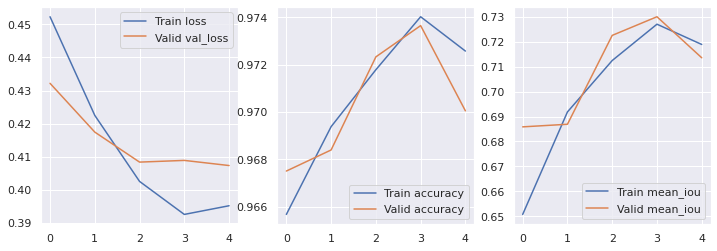

In [ ]:
plot_his(history)

#### plot mask

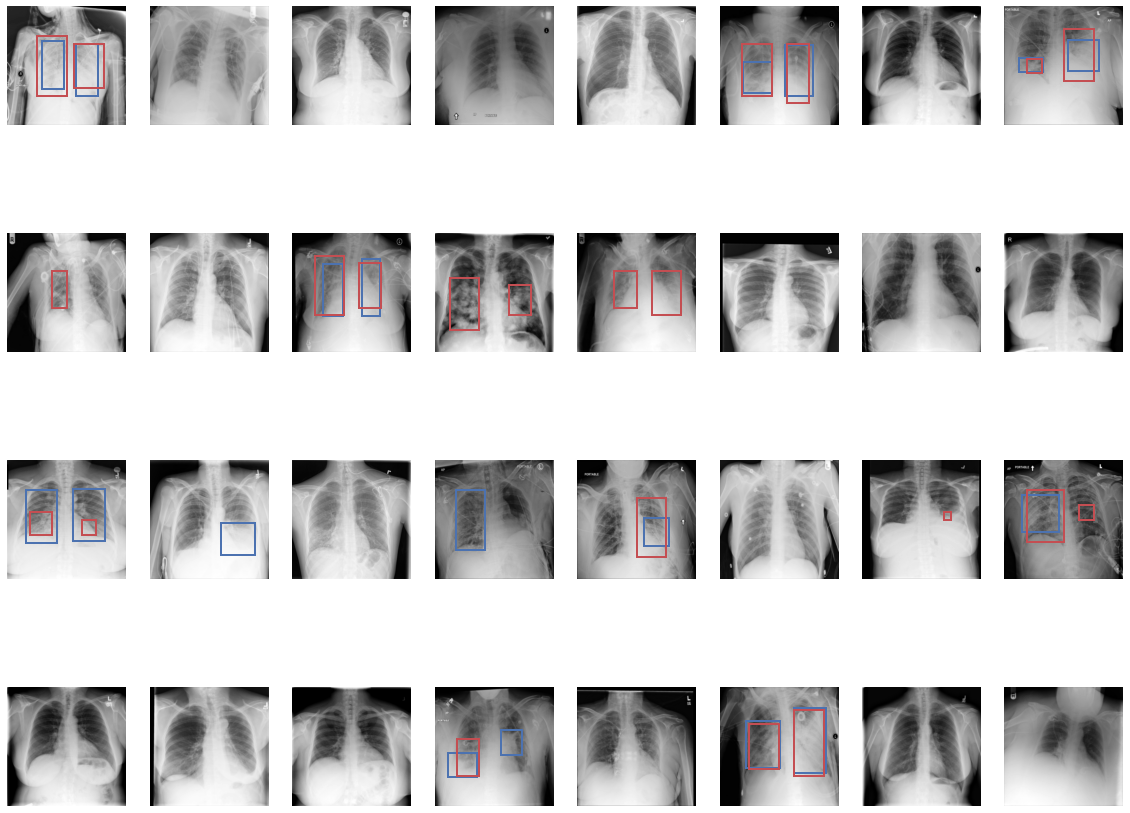

In [ ]:
#Display on one batch for validation set.
disply_mask(valid_gen,model)

#### Metric score

In [ ]:
TEST_FILES = test_f
test_gen = MyDataGenerator(folder, TEST_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

### Unet-Mobile Segmentation(option2)
   Transfer learning

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

ALPHA = 0.75
def create_unet_model(im_height,im_width,trainable=True):
    model = MobileNet(input_shape=(im_height, im_width, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    
    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((im_height, im_height))(x)

    
    return Model(inputs=model.input, outputs=x)

   

In [ ]:
IMAGE_SIZE=224
unet_model = create_unet_model(IMAGE_SIZE,IMAGE_SIZE,False)
unet_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 24) 648         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 24) 96          conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
#Create a function to calculate dice coefficient
from tensorflow.keras.backend import log, epsilon
from tensorflow import reduce_sum
def dice_coefficient(y_true, y_pred):
  # print(y_pred.shape,y_true.shape)
  numerator = 2 * reduce_sum(y_true * y_pred)
  denominator = reduce_sum(y_true + y_pred)

  return numerator / (denominator + epsilon())

In [ ]:
#Define loss
from tensorflow.keras.losses import binary_crossentropy

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
# def iou_loss(y_true, y_pred):
#     #print(y_true)
#     print(y_pred.shape)
#     y_true=tf.cast(y_true, tf.float32)
#     y_pred=tf.cast(y_pred, tf.float32)
#     y_true = tf.reshape(y_true, [-1])
#     y_pred = tf.reshape(y_pred, [-1])
   
#     intersection = tf.reduce_sum(y_true * y_pred)
#     score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
#     return 1 - score

# # combine bce loss and iou loss
# def iou_bce_loss(y_true, y_pred):
#     return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# # mean iou as a metric
# def mean_iou(y_true, y_pred):
#     y_pred = tf.round(y_pred)
#     intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
#     union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
#     smooth = tf.ones(tf.shape(intersect))
#     return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
#Compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
unet_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])
# optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou]
# unet_model.compile(loss=iou_bce_loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#check point & early stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
# stop = EarlyStopping(monitor="loss", patience=5, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")


#### Model fit

In [ ]:
BATCH_SIZE = 16
selectDataSet()
train_gen = MyDataGenerator("Mobilenet UNET Train", TRAIN_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False,isRGB=True)
valid_gen = MyDataGenerator("Mobilenet UNET Valid", VALID_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False,isRGB=True)

Mobilenet UNET Train data generator with image size:224X224
Mobilenet UNET Valid data generator with image size:224X224


In [ ]:
%%time
import time
import pickle

model_basic_cnn_file = 'mobile_unet.h5'
history_file = 'mobile_unet_his.pkl'
unet_his = {}
FORCE_TRAINING = True
isSaving = True

if (os.path.isfile(model_basic_cnn_file) & (FORCE_TRAINING == False) ):
  isSaving =False
  model.load_weights(model_basic_cnn_file)
  unet_his = loadHistory(history_file)
else:
  EPOCHS = 5
  unet_his = unet_model.fit(train_gen, validation_data=valid_gen,epochs=EPOCHS,verbose=1)


NameError: ignored

#### plot history

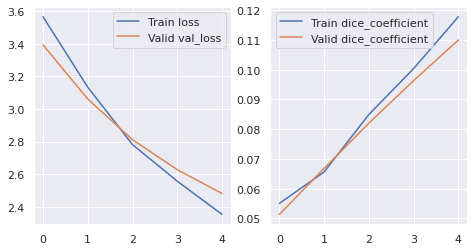

In [ ]:
if (isSaving):
  model.save(model_basic_cnn_file)
  #Saving hostory
  unet_his = saveHistory(unet_his,history_file)
metric = ['loss','val_loss','dice_coefficient','val_dice_coefficient']
plot_his(unet_his,metric)


#### plot mask

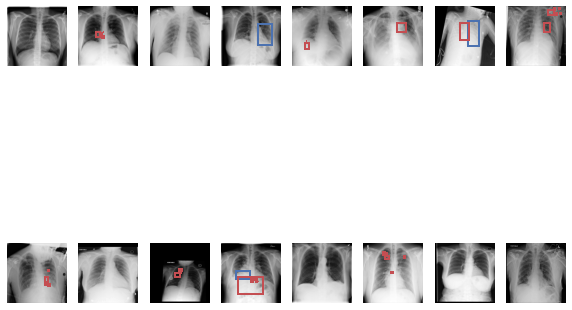

In [ ]:
disply_mask(valid_gen,unet_model)

## 

EXP data generator with image size:224X224
(224, 224, 3) (224, 224)
2


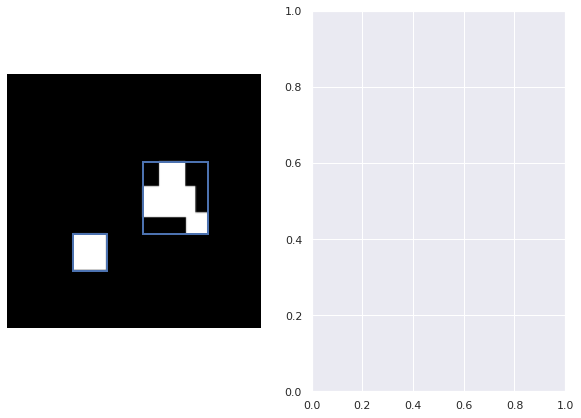

In [ ]:
from skimage import measure
import matplotlib.patches as patches
BBOX_MAP = bbox_map
BATCH_SIZE = 16
IMAGE_SIZE = 224
myexp()

16

### VGG Net(option2)
   Transfer learning
  

## Milestone-1 Conclusion

## Milestone-2

### Hybrind model(option-1)
   


### Pre-Processing module
  In this module, class feature will be label encoded. Also image data generator will scale the image to required size with encoded class label.

In [94]:
#Do one hot encoding for stage1 classification target.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
pd_class_info['class_id'] = class_enc.fit_transform(pd_class_info['class'])
oh_enc = OneHotEncoder(sparse=False)
pd_class_info['class_vector'] = oh_enc.fit_transform(
    pd_class_info['class_id'].values.reshape(-1, 1)).tolist() 
pd_class_info.head()


,patientId,class,class_id,class_vector
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]"
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,2,"[0.0, 0.0, 1.0]"
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,0,"[1.0, 0.0, 0.0]"


In [95]:
df_meta.head()

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19,1,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28,1,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,32,0,1


In [96]:
pd_hybrid = pd.concat([df_meta,pd_class_info.drop('patientId',1),df_final['path']],1)
pd_hybrid.to_csv('image_bbox_full.csv')

In [97]:
CLASS_VECTORS = {}
def get_class_map(df_pn):
  class_map = {}
  for n, row in df_pn.iterrows():
    pid = row['patientId']
    if pid not in class_map:
      class_map[row.patientId] = row['class_vector']
  return class_map
CLASS_VECTORS = get_class_map(pd_hybrid)

In [98]:
def TestGenerator(gen):
  batch = gen.batch_size
  row = int(batch/8)
  # print(row)
  i = 0
  for imgs, labels in gen:    
      f, ax = plt.subplots(row, 8, figsize=(5*row,4*row))
      ax = ax.ravel()
      idx = 0
      
      for img, label in zip(imgs, labels):
          # print(img.shape)
          i=i+1
          if i>32:
              break
          print("Label :",label)
          #Show xray
          ax[idx].imshow(img[:, :, 0],cmap=plt.cm.gist_gray)
          ax[idx].axis('off')
          idx +=1
          
      break

In [99]:
selectDataSet(True)
# IMAGE_SIZE384
train_gen = MyDataGenerator("CNN Classification Train", TRAIN_FILES, CLASS_VECTORS,BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False,isRGB=True,isClass=True)
valid_gen = MyDataGenerator("CNN Classification Valid", VALID_FILES,CLASS_VECTORS, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False,isRGB=True,isClass=True)

CNN Classification Train data generator with image size:256X256
CNN Classification Valid data generator with image size:256X256


Label : [0. 0. 1.]
Label : [1. 0. 0.]
Label : [0. 0. 1.]
Label : [0. 0. 1.]
Label : [0. 1. 0.]
Label : [1. 0. 0.]
Label : [1. 0. 0.]
Label : [0. 1. 0.]
Label : [1. 0. 0.]
Label : [0. 1. 0.]
Label : [0. 0. 1.]
Label : [0. 1. 0.]
Label : [1. 0. 0.]
Label : [0. 0. 1.]
Label : [1. 0. 0.]
Label : [0. 1. 0.]
Label : [1. 0. 0.]
Label : [0. 1. 0.]
Label : [1. 0. 0.]
Label : [1. 0. 0.]
Label : [0. 0. 1.]
Label : [0. 1. 0.]
Label : [0. 1. 0.]
Label : [0. 1. 0.]
Label : [1. 0. 0.]
Label : [0. 1. 0.]
Label : [0. 1. 0.]
Label : [0. 1. 0.]
Label : [0. 0. 1.]
Label : [0. 0. 1.]
Label : [0. 1. 0.]
Label : [0. 0. 1.]


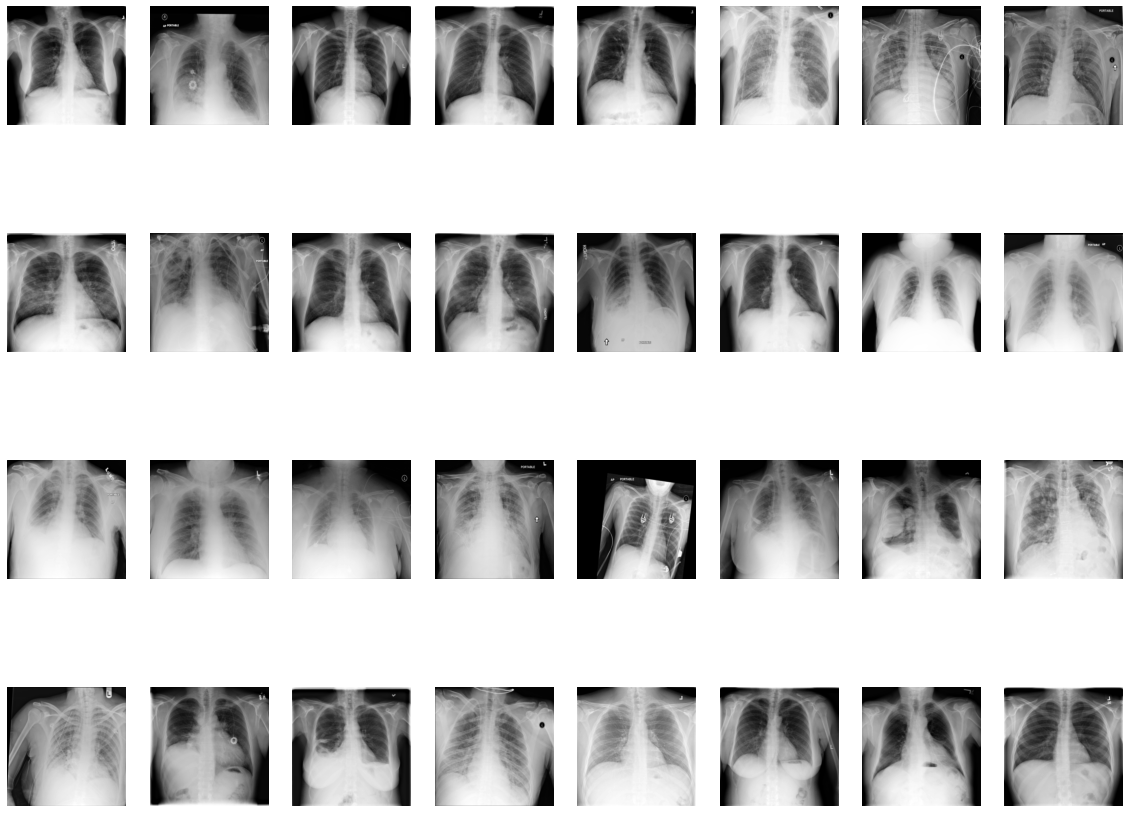

In [107]:
TestGenerator(train_gen)

### Classification module
 Below is high level architecture of classification module. It contains two stage. Stage 1 is the class prediction & stage 2 is Target prediction.
![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/Classification_module.PNG)





In [103]:
# We will be experimenting with various model, but based on imagenet compettition result,
# we will be using InceptionResNetV2,InceptionV3 & DenseNet121
BASE_MODEL = "InceptionResNetV2"
BASE_MODEL = 'VGG16'

In [104]:

if BASE_MODEL == 'InceptionResNetV2':
  from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as BaseModel,preprocess_input
elif BASE_MODEL=='InceptionV3':
    from tensorflow.keras.applications.inception_v3 import InceptionV3 as BaseModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from tensorflow.keras.applications.densenet import DenseNet121 as BaseModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from tensorflow.keras.applications.vgg16 import VGG16 as BaseModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from tensorflow.keras.applications.resnet50 import ResNet50 as BaseModel, preprocess_input
elif BASE_MODEL=='Xception':
    from tensorflow.keras.applications.xception import Xception as BaseModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from tensorflow.keras.applications.densenet import DenseNet169 as BaseModel, preprocess_input



#### Stage1 "class" Classification

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/classification_stage1.PNG)

In [105]:
DROPOUT = 0.25 # [0, 0.25, 0.5]
DENSE_COUNT = 128 # [32, 64, 128, 256]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
def build_pretrained_model():
  base_pretrained_model = BaseModel(input_shape =  (IMAGE_SIZE, IMAGE_SIZE, 3), 
                              include_top = False, weights = 'imagenet')
  base_pretrained_model.trainable = False

  pt_features = Input((8,8,512), name = 'feature_input')
    
  bn_features = BatchNormalization()(pt_features)
  gap = GlobalAveragePooling2D()(bn_features)

  gap_dr = Dropout(DROPOUT)(gap)
  dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
  dr_steps = BatchNormalization()(dr_steps)
  dr_steps = layers.LeakyReLU(0.1)(dr_steps)
  out_layer = Dense(3, activation = 'softmax')(dr_steps)

  attn_model = Model(inputs = [pt_features], 
                    outputs = [out_layer], name = 'trained_model')
  
  pneu_model = Sequential(name = 'combined_model')
  base_pretrained_model.trainable = False
  pneu_model.add(base_pretrained_model)
  pneu_model.add(attn_model)
  pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
  
  return pneu_model

In [106]:
# base_pretrained_model = BaseModel(input_shape =  (IMAGE_SIZE, IMAGE_SIZE, 3), 
#                               include_top = False, weights = 'imagenet')
# base_pretrained_model.summary()
# from keras.utils.vis_utils import plot_model
# plot_model(base_pretrained_model)

In [107]:
# base_pretrained_model.summary()

In [108]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential


class_model = build_pretrained_model()
class_model.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
trained_model (Functional)   (None, 3)                 68483     
Total params: 14,783,171
Trainable params: 67,203
Non-trainable params: 14,715,968
_________________________________________________________________


In [109]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [111]:
class_model.load_weights(weight_path)
# history = class_model.fit(train_gen, 
#                          validation_data=valid_gen, 
#                          epochs=1, 
#                          callbacks=callbacks_list,
#                          workers=6)


In [ ]:
class_model.load_weights(weight_path)
class_model.save('full_model.h5')

In [112]:
FULL_FILES = test_f_reduce
predict_gen = MyDataGenerator("CNN Classification Predict", TEST_FILES,CLASS_VECTORS, BBOX_MAP,
                              batch_size=32, 
                      image_size=IMAGE_SIZE, 
                      shuffle=False, predict=True,isRGB=True,isClass=True)

CNN Classification Predict data generator with image size:256X256


In [125]:
#Predict for all patients & create a datafram from prediction
from tqdm import tqdm
def Predict(gen,model):
  patients = []
  class_vectors = []
  for imgs, dcms in tqdm(gen):
      print() 
      print("Predicting image of length:",len(dcms))   
      pred_vectors = model.predict(imgs)
      for pred in pred_vectors:
        class_vectors.append(pred)
      for f in dcms:
        patients.append(f)
      
  return patients, class_vectors
          
patients, class_vectors = Predict(predict_gen,class_model)




Predicting image of length: 32



  6%|▋         | 8/126 [03:02<46:07, 23.45s/it]


Predicting image of length: 32



  7%|▋         | 9/126 [03:28<47:05, 24.15s/it]


Predicting image of length: 32



  8%|▊         | 10/126 [03:54<47:55, 24.79s/it]


Predicting image of length: 32



  9%|▊         | 11/126 [04:20<48:01, 25.06s/it]


Predicting image of length: 32



 10%|▉         | 12/126 [04:45<47:38, 25.07s/it]


Predicting image of length: 32



 10%|█         | 13/126 [05:10<47:12, 25.06s/it]


Predicting image of length: 32



 11%|█         | 14/126 [05:35<46:58, 25.16s/it]


Predicting image of length: 32



 12%|█▏        | 15/126 [06:00<46:17, 25.02s/it]


Predicting image of length: 32



 13%|█▎        | 16/126 [06:25<45:44, 24.95s/it]


Predicting image of length: 32



 13%|█▎        | 17/126 [06:50<45:18, 24.94s/it]


Predicting image of length: 32



 14%|█▍        | 18/126 [07:15<44:51, 24.93s/it]


Predicting image of length: 32



 15%|█▌        | 19/126 [07:40<44:50, 25.14s/it]


Predicting image of length: 32



 16%|█▌        | 20/126 [08:06<44:23, 25.12s/it]


Predicting image of length: 32



 17%|█▋        | 21/126 [08:32<44:31, 25.45s/it]


Predicting image of length: 32



 17%|█▋        | 22/126 [08:57<44:16, 25.55s/it]


Predicting image of length: 32



 18%|█▊        | 23/126 [09:22<43:20, 25.25s/it]


Predicting image of length: 32



 19%|█▉        | 24/126 [09:47<42:46, 25.16s/it]


Predicting image of length: 32



 20%|█▉        | 25/126 [10:11<41:59, 24.94s/it]


Predicting image of length: 32



 21%|██        | 26/126 [10:35<41:05, 24.66s/it]


Predicting image of length: 32



 21%|██▏       | 27/126 [11:01<41:00, 24.85s/it]


Predicting image of length: 32



 22%|██▏       | 28/126 [11:26<40:36, 24.87s/it]


Predicting image of length: 32



 23%|██▎       | 29/126 [11:51<40:12, 24.87s/it]


Predicting image of length: 32



 24%|██▍       | 30/126 [12:14<39:12, 24.50s/it]


Predicting image of length: 32



 25%|██▍       | 31/126 [12:38<38:28, 24.30s/it]


Predicting image of length: 32



 25%|██▌       | 32/126 [13:02<37:53, 24.18s/it]


Predicting image of length: 32



 26%|██▌       | 33/126 [13:27<37:51, 24.42s/it]


Predicting image of length: 32



 27%|██▋       | 34/126 [13:51<37:25, 24.41s/it]


Predicting image of length: 32



 28%|██▊       | 35/126 [14:16<37:04, 24.45s/it]


Predicting image of length: 32



 29%|██▊       | 36/126 [14:41<37:08, 24.77s/it]


Predicting image of length: 32



 29%|██▉       | 37/126 [15:06<36:35, 24.67s/it]


Predicting image of length: 32



 30%|███       | 38/126 [15:31<36:28, 24.87s/it]


Predicting image of length: 32



 31%|███       | 39/126 [15:57<36:22, 25.09s/it]


Predicting image of length: 32



 32%|███▏      | 40/126 [16:21<35:41, 24.90s/it]


Predicting image of length: 32



 33%|███▎      | 41/126 [16:47<35:34, 25.11s/it]


Predicting image of length: 32



 33%|███▎      | 42/126 [17:12<35:03, 25.05s/it]


Predicting image of length: 32



 34%|███▍      | 43/126 [17:37<34:51, 25.20s/it]


Predicting image of length: 32



 35%|███▍      | 44/126 [18:03<34:31, 25.26s/it]


Predicting image of length: 32



 36%|███▌      | 45/126 [18:27<33:54, 25.12s/it]


Predicting image of length: 32



 37%|███▋      | 46/126 [18:53<33:39, 25.24s/it]


Predicting image of length: 32



 37%|███▋      | 47/126 [19:20<34:00, 25.83s/it]


Predicting image of length: 32



 38%|███▊      | 48/126 [19:46<33:25, 25.71s/it]


Predicting image of length: 32



 39%|███▉      | 49/126 [20:10<32:36, 25.41s/it]


Predicting image of length: 32



 40%|███▉      | 50/126 [20:35<32:07, 25.36s/it]


Predicting image of length: 32



 40%|████      | 51/126 [21:00<31:28, 25.18s/it]


Predicting image of length: 32



 41%|████▏     | 52/126 [21:26<31:20, 25.41s/it]


Predicting image of length: 32



 42%|████▏     | 53/126 [21:51<30:38, 25.18s/it]


Predicting image of length: 32



 43%|████▎     | 54/126 [22:16<30:05, 25.07s/it]


Predicting image of length: 32



 44%|████▎     | 55/126 [22:40<29:23, 24.84s/it]


Predicting image of length: 32



 44%|████▍     | 56/126 [23:04<28:35, 24.51s/it]


Predicting image of length: 32



 45%|████▌     | 57/126 [23:28<28:08, 24.47s/it]


Predicting image of length: 32



 46%|████▌     | 58/126 [23:51<27:19, 24.12s/it]


Predicting image of length: 32



 47%|████▋     | 59/126 [24:15<26:48, 24.01s/it]


Predicting image of length: 32



 48%|████▊     | 60/126 [24:40<26:43, 24.30s/it]


Predicting image of length: 32



 48%|████▊     | 61/126 [25:05<26:30, 24.47s/it]


Predicting image of length: 32



 49%|████▉     | 62/126 [25:29<26:04, 24.45s/it]


Predicting image of length: 32



 50%|█████     | 63/126 [25:55<25:53, 24.66s/it]


Predicting image of length: 32



 51%|█████     | 64/126 [26:20<25:40, 24.85s/it]


Predicting image of length: 32



 52%|█████▏    | 65/126 [26:45<25:17, 24.89s/it]


Predicting image of length: 32



 52%|█████▏    | 66/126 [27:08<24:20, 24.34s/it]


Predicting image of length: 32



 53%|█████▎    | 67/126 [27:33<24:11, 24.60s/it]


Predicting image of length: 32



 54%|█████▍    | 68/126 [27:58<23:52, 24.70s/it]


Predicting image of length: 32



 55%|█████▍    | 69/126 [28:22<23:21, 24.59s/it]


Predicting image of length: 32



 56%|█████▌    | 70/126 [28:47<23:02, 24.69s/it]


Predicting image of length: 32



 56%|█████▋    | 71/126 [29:12<22:30, 24.56s/it]


Predicting image of length: 32



 57%|█████▋    | 72/126 [29:37<22:13, 24.70s/it]


Predicting image of length: 32



 58%|█████▊    | 73/126 [30:01<21:48, 24.68s/it]


Predicting image of length: 32



 59%|█████▊    | 74/126 [30:26<21:21, 24.64s/it]


Predicting image of length: 32



 60%|█████▉    | 75/126 [30:51<21:06, 24.84s/it]


Predicting image of length: 32



 60%|██████    | 76/126 [31:16<20:46, 24.92s/it]


Predicting image of length: 32



 61%|██████    | 77/126 [31:42<20:27, 25.06s/it]


Predicting image of length: 32



 62%|██████▏   | 78/126 [32:07<20:02, 25.05s/it]


Predicting image of length: 32



 63%|██████▎   | 79/126 [32:33<19:58, 25.51s/it]


Predicting image of length: 32



 63%|██████▎   | 80/126 [32:57<19:13, 25.07s/it]


Predicting image of length: 32



 64%|██████▍   | 81/126 [33:22<18:51, 25.14s/it]


Predicting image of length: 32



 65%|██████▌   | 82/126 [33:46<18:07, 24.71s/it]


Predicting image of length: 32



 66%|██████▌   | 83/126 [34:11<17:45, 24.78s/it]


Predicting image of length: 32



 67%|██████▋   | 84/126 [34:37<17:37, 25.18s/it]


Predicting image of length: 32



 67%|██████▋   | 85/126 [35:01<16:59, 24.86s/it]


Predicting image of length: 32



 68%|██████▊   | 86/126 [35:26<16:32, 24.81s/it]


Predicting image of length: 32



 69%|██████▉   | 87/126 [35:51<16:03, 24.71s/it]


Predicting image of length: 32



 70%|██████▉   | 88/126 [36:16<15:46, 24.90s/it]


Predicting image of length: 32



 71%|███████   | 89/126 [36:42<15:34, 25.26s/it]


Predicting image of length: 32



 71%|███████▏  | 90/126 [37:07<15:12, 25.34s/it]


Predicting image of length: 32



 72%|███████▏  | 91/126 [37:32<14:37, 25.07s/it]


Predicting image of length: 32



 73%|███████▎  | 92/126 [37:57<14:08, 24.94s/it]


Predicting image of length: 32



 74%|███████▍  | 93/126 [38:24<14:12, 25.82s/it]


Predicting image of length: 32



 75%|███████▍  | 94/126 [38:49<13:37, 25.54s/it]


Predicting image of length: 32



 75%|███████▌  | 95/126 [39:14<13:03, 25.29s/it]


Predicting image of length: 32



 76%|███████▌  | 96/126 [39:39<12:32, 25.07s/it]


Predicting image of length: 32



 77%|███████▋  | 97/126 [40:04<12:09, 25.17s/it]


Predicting image of length: 32



 78%|███████▊  | 98/126 [40:29<11:42, 25.07s/it]


Predicting image of length: 32



 79%|███████▊  | 99/126 [40:55<11:23, 25.32s/it]


Predicting image of length: 32



 79%|███████▉  | 100/126 [41:19<10:49, 24.98s/it]


Predicting image of length: 32



 80%|████████  | 101/126 [41:44<10:26, 25.05s/it]


Predicting image of length: 32



 81%|████████  | 102/126 [42:09<10:02, 25.10s/it]


Predicting image of length: 32



 82%|████████▏ | 103/126 [42:33<09:28, 24.73s/it]


Predicting image of length: 32



 83%|████████▎ | 104/126 [42:58<09:06, 24.83s/it]


Predicting image of length: 32



 83%|████████▎ | 105/126 [43:24<08:44, 24.98s/it]


Predicting image of length: 32



 84%|████████▍ | 106/126 [43:49<08:23, 25.17s/it]


Predicting image of length: 32



 85%|████████▍ | 107/126 [44:15<07:59, 25.26s/it]


Predicting image of length: 32



 86%|████████▌ | 108/126 [44:40<07:35, 25.32s/it]


Predicting image of length: 32



 87%|████████▋ | 109/126 [45:06<07:10, 25.34s/it]


Predicting image of length: 32



 87%|████████▋ | 110/126 [45:31<06:45, 25.36s/it]


Predicting image of length: 32



 88%|████████▊ | 111/126 [45:57<06:24, 25.66s/it]


Predicting image of length: 32



 89%|████████▉ | 112/126 [46:22<05:56, 25.43s/it]


Predicting image of length: 32



 90%|████████▉ | 113/126 [46:48<05:30, 25.44s/it]


Predicting image of length: 32



 90%|█████████ | 114/126 [47:12<05:01, 25.14s/it]


Predicting image of length: 32



 91%|█████████▏| 115/126 [47:37<04:34, 24.99s/it]


Predicting image of length: 32



 92%|█████████▏| 116/126 [48:03<04:12, 25.23s/it]


Predicting image of length: 32



 93%|█████████▎| 117/126 [48:27<03:45, 25.04s/it]


Predicting image of length: 32



 94%|█████████▎| 118/126 [48:52<03:20, 25.05s/it]


Predicting image of length: 32



 94%|█████████▍| 119/126 [49:18<02:56, 25.26s/it]


Predicting image of length: 32



 95%|█████████▌| 120/126 [49:43<02:31, 25.22s/it]


Predicting image of length: 32



 96%|█████████▌| 121/126 [50:08<02:05, 25.03s/it]


Predicting image of length: 32



 97%|█████████▋| 122/126 [50:33<01:40, 25.21s/it]


Predicting image of length: 32



 98%|█████████▊| 123/126 [50:57<01:14, 24.91s/it]


Predicting image of length: 32



 98%|█████████▊| 124/126 [51:22<00:49, 24.76s/it]


Predicting image of length: 32



 99%|█████████▉| 125/126 [51:47<00:24, 24.82s/it]


Predicting image of length: 3



100%|██████████| 126/126 [51:50<00:00, 24.69s/it]


In [126]:
def get_prediction_map(patients,class_vecs):
  pred_map = {}
  for  idx,filename in enumerate(patients):
    file = filename.split('/')[1]
    patient = file.split('.')[0]
    if patient not in pred_map:
      classes = class_vecs[idx]
      pred_map[patient] = {'PNEUMONIA':classes[0],'NOT_NORMAL':classes[1], "NORMAL":classes[2] }
  df = pd.DataFrame(pred_map).T
  return df
pred_df = get_prediction_map(patients,class_vectors)

In [127]:
pred_df.head()

,PNEUMONIA,NOT_NORMAL,NORMAL
a5e4533f-113e-4a3a-8a9f-c0873d172e48,0.017464,0.079862,0.902675
00ddefb9-d94e-4e86-b945-970be30483d7,0.015259,0.106802,0.877939
922883eb-afd7-4314-91f4-95e8e3567f4d,0.358489,0.565191,0.076319
55f2e30e-005f-4aa3-b4bf-f16ac2b8c11f,0.265650,0.675310,0.059040
7f150b75-9a9c-44a6-94a2-4846c4154254,0.120080,0.437404,0.442516


In [128]:
pred_df.to_csv('pred_df.csv')

#### Stage2 "Target" classification

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/classification_stage2.PNG)

In [ ]:
#Build neural netwrok
def add_layer(model):
  kinit ='he_normal' #tf.keras.initializers.he_normal()
  actv = 'relu' #activation.relu
  model.add(Reshape((6,),input_shape=(32,32,)))
  #Add batch normalization to avoid NAN in training loss
  model.add(kl.normalization.BatchNormalization())
  #Add input layer -- Number of input neuron = 1024 (as the number of variable) +1(for bias)
  model.add(Dense(6,activation=actv,kernel_initializer=kinit))

  #How many hidden layer? No clear rule, trial & error? Literature says, it 3 hidden layer sufficient
  #Add hidden layer -1
  model.add(Dense(16,activation=actv,kernel_initializer=kinit))
  #Add hidden layer -2
  model.add(Dense(8,activation=actv,kernel_initializer=kinit))
  #Add hidden layer -3
  model.add(Dense(4,activation=actv,kernel_initializer=kinit))


  #Add output layer -- number of output neoron 1(as the number of output is 10)
  #Add hidden layer -1
  model.add(Dense(1,activation='sigmoid',kernel_initializer=kinit))
  
nn_model = Sequential()
add_layer(nn_model)

In [ ]:
def fit_model(opt,model,epoch=30,verbo=0,batchsize=128,x_v=X_val_orig,y_v=y_val):
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(X_train_orig, y_train, validation_data=(x_v,y_v),batch_size=batchsize, epochs=epoch, verbose=verbo)
  return history
opt = Adam(lr = LEARN_RATE)
nn_history = fit_model(opt,nn_model)

### Object detention module

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/detection_module.PNG)

## Performance comparison 

## Conclusion